# Opening Range Breakout (ORB) Indicator

**Formula**: 
- **OR High** = Highest high during first N minutes of trading session
- **OR Low** = Lowest low during first N minutes of trading session
- **OR Mid** = (OR High + OR Low) / 2
- **OR Range** = OR High - OR Low

**Interpretation**:
- Opening Range represents the initial supply/demand equilibrium
- Acts as a key support/resistance level for the entire trading day
- Wider opening range signals higher expected volatility
- Consolidation within OR indicates indecision

**Key Signals**:
- **Breakout Above OR High** = Bullish signal (buying pressure exceeded opening resistance)
- **Breakout Below OR Low** = Bearish signal (selling pressure exceeded opening support)
- **Failed Breakout** = Price breaks OR but reverses (fade the break strategy, opposite entry)
- **Confirmation** = High volume during breakout increases reliability

**Common Strategies**:
1. **Classic ORB**: Buy on breakout above OR high, sell on breakout below OR low
2. **First Pullback**: Wait for breakout, then buy pullback to OR
3. **Fade the Break**: Short failed breakouts above OR high (counter-trend)
4. **OR Width**: Small OR after wide OR can signal potential breakout

In [1]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from indikator import opening_range

plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42)

## Scenario 1: Opening Range Breakout (ORB)
Price consolidates within the opening range, then breaks out above OR high with strong volume

/tmp/sselcuk/ipykernel_1244403/2181074967.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


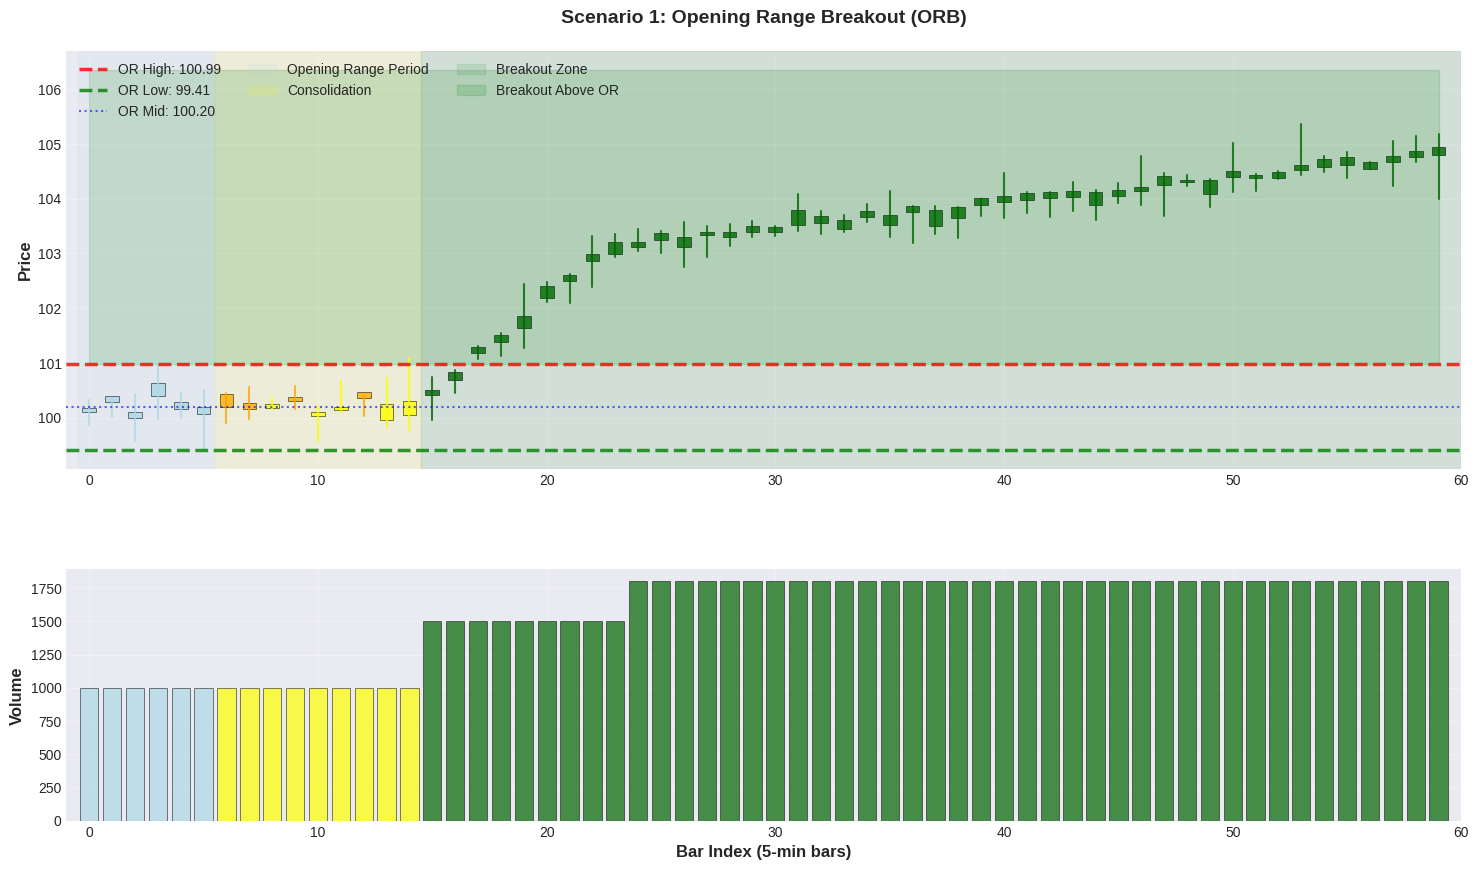

Opening Range Analysis - ORB Scenario:
  OR High: 100.99
  OR Low:  99.41
  OR Range: 1.58

Breakout Details:
  Breakout begins at bar 15 (price: 100.50)
  Peak price: 104.80
  Distance from OR High: 3.81

Volume Analysis:
  OR volume: 1000
  Consolidation volume: 1000
  Breakout volume: 1740
  Volume increase: 74.0%


In [2]:
# Create intraday 5-minute data with ORB pattern
# Opening range: 09:30 - 10:00 (6 bars at 5min intervals)
# Consolidation: 10:00 - 10:45 (9 bars)
# Breakout: 10:45 - 11:30 (9 bars)

n_total = 60
dates = pd.date_range('2024-01-15 09:30', periods=n_total, freq='5min')

# Opening range: tight range at 100-101
or_closes = np.array([100.1, 100.3, 100.0, 100.4, 100.2, 100.1])

# Consolidation: stays within OR bounds (100.0 - 100.4)
consolidation = np.array([100.2, 100.15, 100.25, 100.3, 100.1, 100.2, 100.35, 100.25, 100.3])

# Breakout: price breaks above 100.4 and continues higher
breakout = np.linspace(100.5, 103.2, 9)
continuation = np.linspace(103.2, 104.8, 36)

closes = np.concatenate([or_closes, consolidation, breakout, continuation])

# Create OHLC data
opens = closes + np.random.randn(n_total) * 0.15
highs = np.maximum(opens, closes) + np.abs(np.random.randn(n_total)) * 0.3
lows = np.minimum(opens, closes) - np.abs(np.random.randn(n_total)) * 0.3

# Volume increases during breakout
volumes = np.ones(n_total) * 1000
volumes[15:24] *= 1.5  # Higher volume during breakout
volumes[24:] *= 1.8

df_orb = pd.DataFrame({
    'open': opens,
    'high': highs,
    'low': lows,
    'close': closes,
    'volume': volumes
}, index=dates)

# Calculate opening range (30 minutes = 6 bars at 5min)
result_orb = opening_range(df_orb, minutes=30, session_start='09:30')

# Plot
fig = plt.figure(figsize=(18, 10))
gs = GridSpec(2, 1, height_ratios=[2.5, 1.5], hspace=0.3)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)

# Define zones
or_end_idx = 6  # 30 minutes = 6 bars
breakout_start_idx = 15  # Where breakout begins

# Candlesticks
for i in range(len(df_orb)):
    if i < or_end_idx:
        # Opening range bars
        color = 'lightblue'
    elif i < breakout_start_idx:
        # Consolidation bars
        color = 'yellow' if df_orb['close'].iloc[i] >= df_orb['open'].iloc[i] else 'orange'
    else:
        # Breakout bars
        color = 'darkgreen'
    
    ax1.plot([i, i], [df_orb['low'].iloc[i], df_orb['high'].iloc[i]], 
             color=color, linewidth=1.5, alpha=0.8)
    
    height = abs(df_orb['close'].iloc[i] - df_orb['open'].iloc[i])
    if height < 0.05:
        height = 0.12
    bottom = min(df_orb['open'].iloc[i], df_orb['close'].iloc[i])
    ax1.add_patch(plt.Rectangle((i - 0.3, bottom), 0.6, height, 
                                facecolor=color, edgecolor='black', linewidth=0.5, alpha=0.8))

# OR levels as horizontal lines
or_high = result_orb['or_high'].iloc[0]
or_low = result_orb['or_low'].iloc[0]
or_mid = result_orb['or_mid'].iloc[0]

ax1.axhline(or_high, color='red', linestyle='--', linewidth=2.5, label=f'OR High: {or_high:.2f}', alpha=0.8)
ax1.axhline(or_low, color='green', linestyle='--', linewidth=2.5, label=f'OR Low: {or_low:.2f}', alpha=0.8)
ax1.axhline(or_mid, color='blue', linestyle=':', linewidth=1.5, label=f'OR Mid: {or_mid:.2f}', alpha=0.6)

# Highlight zones
ax1.axvspan(-0.5, or_end_idx - 0.5, alpha=0.1, color='lightblue', label='Opening Range Period')
ax1.axvspan(or_end_idx - 0.5, breakout_start_idx - 0.5, alpha=0.1, color='yellow', label='Consolidation')
ax1.axvspan(breakout_start_idx - 0.5, len(df_orb), alpha=0.1, color='green', label='Breakout Zone')

# Breakout level highlight
ax1.fill_between(range(len(df_orb)), or_high, df_orb['high'].max() + 1, 
                  alpha=0.15, color='green', label='Breakout Above OR')

ax1.set_ylabel('Price', fontsize=12, fontweight='bold')
ax1.set_title('Scenario 1: Opening Range Breakout (ORB)', fontsize=14, fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper left', ncol=3, fontsize=10)
ax1.set_xlim(-1, len(df_orb))

# Volume chart
colors_vol = ['lightblue' if i < or_end_idx else 'yellow' if i < breakout_start_idx else 'darkgreen' 
              for i in range(len(df_orb))]
ax2.bar(range(len(df_orb)), df_orb['volume'], color=colors_vol, alpha=0.7, edgecolor='black', linewidth=0.5)
ax2.set_xlabel('Bar Index (5-min bars)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Volume', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-1, len(df_orb))

plt.tight_layout()
plt.show()

# Print analysis
print('Opening Range Analysis - ORB Scenario:')
print(f'  OR High: {or_high:.2f}')
print(f'  OR Low:  {or_low:.2f}')
print(f'  OR Range: {or_high - or_low:.2f}')
print(f'\nBreakout Details:')
print(f'  Breakout begins at bar {breakout_start_idx} (price: {df_orb["close"].iloc[breakout_start_idx]:.2f})')
print(f'  Peak price: {df_orb["close"].max():.2f}')
print(f'  Distance from OR High: {df_orb["close"].max() - or_high:.2f}')
print(f'\nVolume Analysis:')
print(f'  OR volume: {df_orb["volume"].iloc[:or_end_idx].mean():.0f}')
print(f'  Consolidation volume: {df_orb["volume"].iloc[or_end_idx:breakout_start_idx].mean():.0f}')
print(f'  Breakout volume: {df_orb["volume"].iloc[breakout_start_idx:].mean():.0f}')
print(f'  Volume increase: {(df_orb["volume"].iloc[breakout_start_idx:].mean() / df_orb["volume"].iloc[:or_end_idx].mean() - 1) * 100:.1f}%')

## Scenario 2: Failed Breakout (Fade the Break Strategy)
Price breaks above OR high with volume, but fails and reverses - a profitable counter-trend setup

/tmp/sselcuk/ipykernel_1244403/2688872996.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


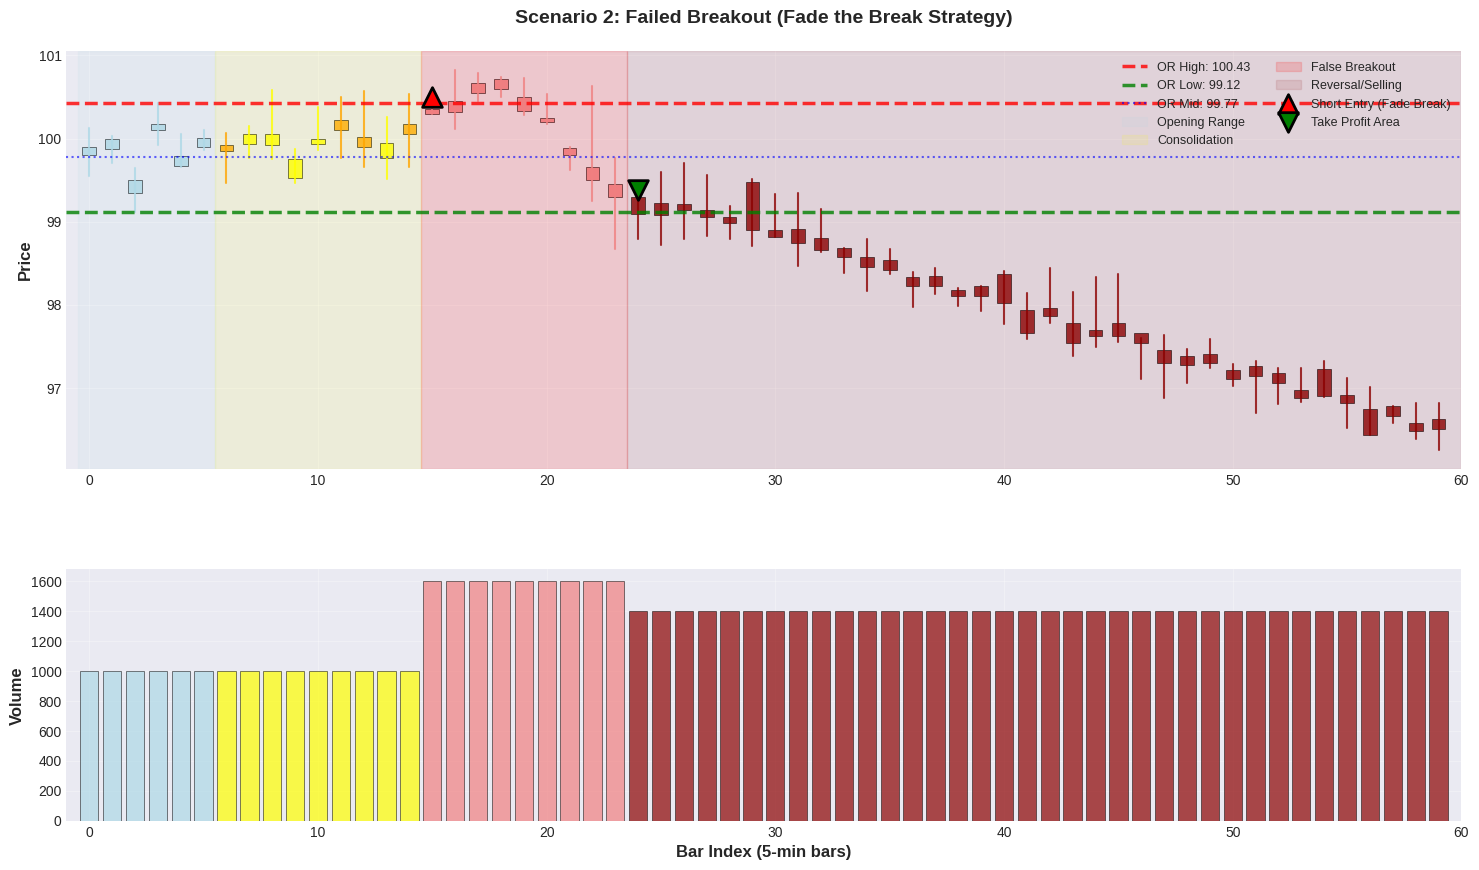

Opening Range Analysis - Failed Breakout (Fade Strategy):
  OR High: 100.43
  OR Low:  99.12
  OR Range: 1.32

False Breakout Details:
  Spike above OR High to: 100.83
  Distance above OR: 0.40
  Reversal point at bar 24
  Final price: 96.50
  Total move from OR High: -3.93

Profit Potential (Fade Strategy):
  Short Entry: 100.50
  Target (OR Low): 99.12
  Potential Profit: 4.00 (3.98%)


In [3]:
# Create intraday 5-minute data with failed breakout pattern
n_total2 = 60
dates2 = pd.date_range('2024-01-16 09:30', periods=n_total2, freq='5min')

# Opening range: tight range at 99-100
or_closes2 = np.array([99.8, 100.0, 99.5, 100.1, 99.7, 99.9])

# Consolidation: stays near OR
consolidation2 = np.array([99.85, 99.95, 100.05, 99.75, 100.0, 100.1, 99.9, 99.95, 100.05])

# False breakout: quick spike above OR high, then sharp reversal
false_breakout = np.array([100.3, 100.45, 100.55, 100.6, 100.5, 100.2, 99.8, 99.5, 99.3])

# Continued selling: price continues lower after failed breakout
selling = np.linspace(99.3, 96.5, 36)

closes2 = np.concatenate([or_closes2, consolidation2, false_breakout, selling])

# Create OHLC data
opens2 = closes2 + np.random.randn(n_total2) * 0.15
highs2 = np.maximum(opens2, closes2) + np.abs(np.random.randn(n_total2)) * 0.3
lows2 = np.minimum(opens2, closes2) - np.abs(np.random.randn(n_total2)) * 0.3

# Volume pattern: high during false breakout, continues elevated during decline
volumes2 = np.ones(n_total2) * 1000
volumes2[15:24] *= 1.6  # High volume during false breakout
volumes2[24:] *= 1.4   # Continued volume during decline

df_fade = pd.DataFrame({
    'open': opens2,
    'high': highs2,
    'low': lows2,
    'close': closes2,
    'volume': volumes2
}, index=dates2)

# Calculate opening range
result_fade = opening_range(df_fade, minutes=30, session_start='09:30')

# Plot
fig = plt.figure(figsize=(18, 10))
gs = GridSpec(2, 1, height_ratios=[2.5, 1.5], hspace=0.3)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)

# Define zones
or_end_idx2 = 6
false_break_start = 15
reversal_start = 24

# Candlesticks
for i in range(len(df_fade)):
    if i < or_end_idx2:
        color = 'lightblue'
    elif i < false_break_start:
        color = 'yellow' if df_fade['close'].iloc[i] >= df_fade['open'].iloc[i] else 'orange'
    elif i < reversal_start:
        color = 'lightcoral'  # False breakout
    else:
        color = 'darkred'  # Selling phase
    
    ax1.plot([i, i], [df_fade['low'].iloc[i], df_fade['high'].iloc[i]], 
             color=color, linewidth=1.5, alpha=0.8)
    
    height = abs(df_fade['close'].iloc[i] - df_fade['open'].iloc[i])
    if height < 0.05:
        height = 0.12
    bottom = min(df_fade['open'].iloc[i], df_fade['close'].iloc[i])
    ax1.add_patch(plt.Rectangle((i - 0.3, bottom), 0.6, height, 
                                facecolor=color, edgecolor='black', linewidth=0.5, alpha=0.8))

# OR levels
or_high2 = result_fade['or_high'].iloc[0]
or_low2 = result_fade['or_low'].iloc[0]
or_mid2 = result_fade['or_mid'].iloc[0]

ax1.axhline(or_high2, color='red', linestyle='--', linewidth=2.5, label=f'OR High: {or_high2:.2f}', alpha=0.8)
ax1.axhline(or_low2, color='green', linestyle='--', linewidth=2.5, label=f'OR Low: {or_low2:.2f}', alpha=0.8)
ax1.axhline(or_mid2, color='blue', linestyle=':', linewidth=1.5, label=f'OR Mid: {or_mid2:.2f}', alpha=0.6)

# Highlight zones
ax1.axvspan(-0.5, or_end_idx2 - 0.5, alpha=0.1, color='lightblue', label='Opening Range')
ax1.axvspan(or_end_idx2 - 0.5, false_break_start - 0.5, alpha=0.1, color='yellow', label='Consolidation')
ax1.axvspan(false_break_start - 0.5, reversal_start - 0.5, alpha=0.15, color='red', label='False Breakout')
ax1.axvspan(reversal_start - 0.5, len(df_fade), alpha=0.1, color='darkred', label='Reversal/Selling')

# Mark entry and exit points
ax1.scatter([false_break_start], [df_fade['high'].iloc[false_break_start]], 
            color='red', s=200, marker='^', zorder=5, label='Short Entry (Fade Break)', edgecolors='black', linewidths=2)
ax1.scatter([reversal_start], [df_fade['high'].iloc[reversal_start]], 
            color='green', s=200, marker='v', zorder=5, label='Take Profit Area', edgecolors='black', linewidths=2)

ax1.set_ylabel('Price', fontsize=12, fontweight='bold')
ax1.set_title('Scenario 2: Failed Breakout (Fade the Break Strategy)', fontsize=14, fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='upper right', ncol=2, fontsize=9)
ax1.set_xlim(-1, len(df_fade))

# Volume chart
colors_vol2 = ['lightblue' if i < or_end_idx2 else 'yellow' if i < false_break_start else 'lightcoral' if i < reversal_start else 'darkred' 
               for i in range(len(df_fade))]
ax2.bar(range(len(df_fade)), df_fade['volume'], color=colors_vol2, alpha=0.7, edgecolor='black', linewidth=0.5)
ax2.set_xlabel('Bar Index (5-min bars)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Volume', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-1, len(df_fade))

plt.tight_layout()
plt.show()

# Print analysis
print('Opening Range Analysis - Failed Breakout (Fade Strategy):')
print(f'  OR High: {or_high2:.2f}')
print(f'  OR Low:  {or_low2:.2f}')
print(f'  OR Range: {or_high2 - or_low2:.2f}')
print(f'\nFalse Breakout Details:')
print(f'  Spike above OR High to: {df_fade["high"].iloc[false_break_start:reversal_start].max():.2f}')
print(f'  Distance above OR: {df_fade["high"].iloc[false_break_start:reversal_start].max() - or_high2:.2f}')
print(f'  Reversal point at bar {reversal_start}')
print(f'  Final price: {df_fade["close"].iloc[-1]:.2f}')
print(f'  Total move from OR High: {df_fade["close"].iloc[-1] - or_high2:.2f}')
print(f'\nProfit Potential (Fade Strategy):')
short_entry = df_fade["high"].iloc[false_break_start]
short_profit = short_entry - df_fade["close"].iloc[reversal_start:].min()
print(f'  Short Entry: {short_entry:.2f}')
print(f'  Target (OR Low): {or_low2:.2f}')
print(f'  Potential Profit: {short_profit:.2f} ({(short_profit / short_entry) * 100:.2f}%)')

## Key Takeaways: Opening Range Breakout Strategy

### ORB Strategy Fundamentals
1. **Setup Requirements**:
   - Identify opening range (first 15-60 minutes of session)
   - Mark clear high and low levels
   - Wait for break above high or below low
   - Confirm with volume surge

2. **Entry Rules**:
   - **Long**: Price breaks above OR high on high volume
   - **Short**: Price breaks below OR low on high volume
   - **Fade**: Short failed breakouts above OR high (counter-trend)

### OR Period Selection
| Period | Best For | Characteristics |
|--------|----------|------------------|
| **15 min** | Very active traders | Tighter range, faster entries, less profit target |
| **30 min** | Day traders (standard) | Balanced, clear levels, reliable breakouts |
| **60 min** | Longer-term intraday | Wider range, bigger moves, more reliable but fewer breakouts |
| **90 min** | Swing-influenced | Extended range, only for high-volatility days |

### Breakout Confirmation with Volume
- **Strong Breakout**: Volume > 150% of OR average + price closes beyond OR level
- **Weak Breakout**: Low volume, price closes at edge of OR (prone to failure)
- **Volume Surge**: Indicates institutional participation and conviction
- **Declining Volume**: Warning sign of false breakout (fade the break)

### Failed Break as Reversal Signal (Fade Strategy)
- **Setup**: Price breaks above/below OR with volume, then reverses
- **Reasoning**: Trapped buyers/sellers create selling/buying pressure
- **Entry**: Short failed high breakout; long failed low breakout
- **Target**: Often reaches opposite OR level (OR low for short, OR high for long)
- **Risk**: Stop loss above/below the failed breakout spike
- **Advantage**: 2:1+ risk/reward, increased probability from squeeze

### Risk Management
- **Stop Loss**: Typically placed beyond OR high/low (plus buffer)
- **Profit Targets**:
  - **Target 1**: OR mid (50% of position)
  - **Target 2**: Opposite OR level
  - **Target 3**: Previous day high/low or pivot level
- **Position Sizing**: Risk fixed % per trade regardless of OR width

### Advanced Observations
1. **OR Width Patterns**:
   - **Wide OR** → Expect big move
   - **Narrow OR** → Contained day or prelude to breakout
   - **Typical Range**: 0.5% - 1.5% of price

2. **Session-Based Behavior**:
   - **Open to 10 AM**: Often chaotic, limit trading
   - **10 AM - 12 PM**: Best ORB opportunities
   - **12-2 PM**: Low volatility (lunch), avoid
   - **2-4 PM**: Second wave breakouts possible

3. **Market Conditions**:
   - **Pre-earnings**: Wide OR expected, high volatility
   - **Earnings day**: Avoid ORB (gap risk)
   - **Fed news days**: Breakouts more reliable
   - **Low volatility days**: Tight OR, avoid weak breakouts

### Best Practices
1. **Always use stop losses** - Market can reverse quickly
2. **Require volume confirmation** - Dry breakouts fail frequently
3. **Test multiple timeframes** - Confirm ORB on 1min and 5min bars
4. **Keep detailed trading log** - Track win rate by OR width and period
5. **Scale into positions** - Don't go all-in on first breakout
6. **Use alerts** - Don't stare at screen, let levels come to you
7. **Combine with other indicators** - RSI divergence, MACD, support/resistance

### Common Mistakes to Avoid
- Trading the actual OR period (noise and whipsaws)
- Ignoring volume (many false breakouts)
- Oversized positions (ORB can reverse quickly)
- Chasing late breakouts (best R:R at initial break)
- Averaging down on losing trades
- Not accounting for gap-open scenarios
- Using same settings for all stocks (volatility varies)

## Feature Showcase: Safety & Configuration

In [4]:
# Configuration & Validation Showcase
# ---------------------------------------------------------
import pandas as pd
import numpy as np
from indikator import opening_range

# 1. Configuration with .Config()
print(f"--- Custom opening_range Configuration ---")
# Create a fully configured version of the indicator
# This factory pattern validates parameters at creation time
custom_opening_range = opening_range.Config(minutes=15).make()
print(f"Created: {custom_opening_range}")

# 2. Validation Safety
print(f"--- Input Validation Safety ---")
try:
    # Attempt to use invalid data (missing columns)
    invalid_data = pd.DataFrame({'close': [100]}) # Missing high/low
    print("Attempting calculation with invalid inputs...")
    opening_range(invalid_data)
except Exception as e:
    # The @validated decorator automatically catches the issue
    print(f"✓ Validator caught error as expected: {e}")


--- Custom opening_range Configuration ---
Created: opening_range(minutes=15)
--- Input Validation Safety ---
Attempting calculation with invalid inputs...
✓ Validator caught error as expected: Validation failed for parameter 'data' in 'opening_range' (HasColumns): Missing columns: ['high', 'low']
